In [12]:

#dog breed indentifier using CNN
# Importing the libraries
import tensorflow as tf


# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# print(gpu_devices)

# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# This disables the GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except e:
    # Invalid device or cannot modify virtual devices once initialized.
    print(e)
    pass

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import cv2
import random
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy


In [13]:
RESULTS_DIR = './results/'
IMG_SIZE = 224

BATCH_SIZE_PRE = 32
BATCH_SIZE_FINE = 32
EPOCHS_PRE = 10
EPOCHS_FINE = 12
MOMENTUM = 0.9

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 10,
    horizontal_flip = True,
    validation_split = 0.2)

train_pre_generator = train_datagen.flow_from_directory(
    directory = "./data/fusion/train/",
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = "rgb",
    batch_size = BATCH_SIZE_PRE,
    class_mode = "categorical")

train_fine_generator = train_datagen.flow_from_directory(
    directory = "./data/fusion/train/",
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = "rgb",
    batch_size = BATCH_SIZE_FINE,
    class_mode = "categorical")

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)
test_generator = test_datagen.flow_from_directory(
    directory = "./data/fusion/test/",
    batch_size = BATCH_SIZE_FINE,
    class_mode = "categorical"
)


Found 18680 images belonging to 172 classes.
Found 18680 images belonging to 172 classes.
Found 9355 images belonging to 172 classes.


In [15]:
assert len(os.listdir('./data/fusion/train/')) == len(os.listdir('./data/fusion/test/'))
num_breeds = len(os.listdir('./data/fusion/train/')) - 1
print("num_breeds:", num_breeds)

num_breeds: 172


In [16]:
mobilenetv2_base_model = mobilenet_v2.MobileNetV2(include_top=False,
                                        weights='imagenet',
                                        input_shape=(IMG_SIZE,IMG_SIZE,3))

x_base_mobilenetv2 = mobilenetv2_base_model.output
x_avg_pooling_mobilenetv2 = GlobalAveragePooling2D()(x_base_mobilenetv2)
x_first_fc_mobilenetv2 = Dense(1024, activation='relu')(x_avg_pooling_mobilenetv2)
x_last_fc_mobilenetv2 = Dense(num_breeds, activation='softmax')(x_first_fc_mobilenetv2)

mobilenetv2_custom_model = Model(inputs=mobilenetv2_base_model.inputs, outputs=x_last_fc_mobilenetv2)

mobilenetv2_custom_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [6]:
#Train model - freeze body layers first
for layer in mobilenetv2_base_model.layers:
    layer.trainable = False

mobilenetv2_custom_model.compile(optimizer=SGD(momentum=MOMENTUM), loss=categorical_crossentropy, metrics=['accuracy'])

model_train_pre = mobilenetv2_custom_model.fit_generator(
    generator = train_pre_generator,
    steps_per_epoch = (train_pre_generator.n//train_pre_generator.batch_size),
    epochs = EPOCHS_PRE,
    validation_data = test_generator,
    validation_steps = (test_generator.n//test_generator.batch_size),
    verbose=1
)

mobilenetv2_custom_model.save(os.path.join(RESULTS_DIR, 'model_pre_mbnet2_4.h5'))

/tmp/ipykernel_358983/3346492357.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_train_pre = mobilenetv2_custom_model.fit_generator(


Epoch 1/10


2022-12-15 08:19:45.263595: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2022-12-15 08:19:46.727002: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-12-15 08:19:46.764037: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-12-15 08:19:46.780614: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-12-15 08:19:46.795066: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25690112 exceeds 10% of free system memory.


583/583 [==============================] - 284s 485ms/step - loss: 1.6833 - accuracy: 0.5750 - val_loss: 1.1098 - val_accuracy: 0.6988
Epoch 2/10
583/583 [==============================] - 271s 465ms/step - loss: 0.8599 - accuracy: 0.7350 - val_loss: 0.9328 - val_accuracy: 0.7311
Epoch 3/10
583/583 [==============================] - 258s 443ms/step - loss: 0.6702 - accuracy: 0.7888 - val_loss: 0.9075 - val_accuracy: 0.7358
Epoch 4/10
583/583 [==============================] - 255s 438ms/step - loss: 0.5427 - accuracy: 0.8259 - val_loss: 0.8840 - val_accuracy: 0.7379
Epoch 5/10
583/583 [==============================] - 256s 439ms/step - loss: 0.4488 - accuracy: 0.8554 - val_loss: 0.8770 - val_accuracy: 0.7350
Epoch 6/10
583/583 [==============================] - 254s 435ms/step - loss: 0.3741 - accuracy: 0.8793 - val_loss: 0.8728 - val_accuracy: 0.7392
Epoch 7/10
583/583 [==============================] - 268s 459ms/step - loss: 0.3119 - accuracy: 0.8989 - val_loss: 0.8640 - val_accura

In [17]:
#Train model - train all layers
for layer in mobilenetv2_base_model.layers:
    layer.trainable = True
    
mobilenetv2_custom_model.compile(optimizer=SGD(momentum=MOMENTUM), loss=categorical_crossentropy, metrics=['accuracy'] )

model_train_fine = mobilenetv2_custom_model.fit_generator(
    generator = train_fine_generator,
    steps_per_epoch = (train_fine_generator.n//train_fine_generator.batch_size),
    epochs = EPOCHS_FINE,
    validation_data = test_generator,
    validation_steps = (test_generator.n//test_generator.batch_size),
    verbose = 1
)

mobilenetv2_custom_model.save(os.path.join(RESULTS_DIR, 'model_fine_mbnet2.h5'))

Epoch 1/12


/tmp/ipykernel_104902/428998347.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_train_fine = mobilenetv2_custom_model.fit_generator(


1167/1167 [==============================] - 701s 599ms/step - loss: 2.5809 - accuracy: 0.3339 - val_loss: 12.4583 - val_accuracy: 0.0079
Epoch 2/12
1167/1167 [==============================] - 707s 606ms/step - loss: 1.9728 - accuracy: 0.4546 - val_loss: 6.5063 - val_accuracy: 0.0691
Epoch 3/12
1167/1167 [==============================] - 719s 616ms/step - loss: 1.6384 - accuracy: 0.5299 - val_loss: 3.9617 - val_accuracy: 0.1809
Epoch 4/12
1167/1167 [==============================] - 716s 614ms/step - loss: 1.4372 - accuracy: 0.5803 - val_loss: 5.4386 - val_accuracy: 0.0971
Epoch 5/12
1167/1167 [==============================] - 714s 612ms/step - loss: 1.2800 - accuracy: 0.6191 - val_loss: 2.8422 - val_accuracy: 0.3264
Epoch 6/12
1167/1167 [==============================] - 714s 612ms/step - loss: 1.1402 - accuracy: 0.6502 - val_loss: 3.3078 - val_accuracy: 0.2501
Epoch 7/12
1167/1167 [==============================] - 712s 610ms/step - loss: 1.0361 - accuracy: 0.6813 - val_loss: 2.30

<built-in method keys of dict object at 0x7faea94d6ec0>


<function matplotlib.pyplot.show(close=None, block=None)>

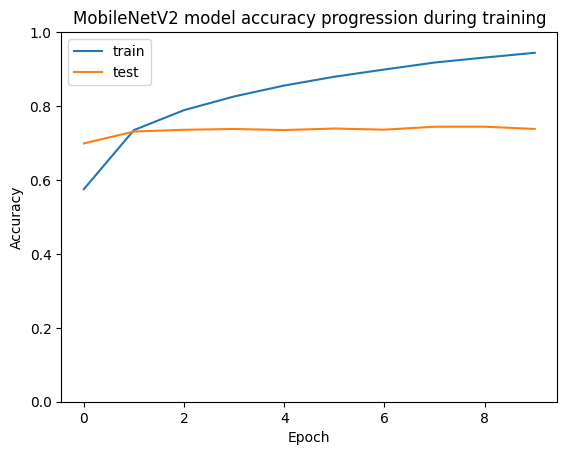

In [23]:
# Display progress of model training
print(model_train_pre.history.keys)
plt.plot(model_train_pre.history['accuracy'])
plt.plot(model_train_pre.history['val_accuracy'])
plt.title('MobileNetV2 model accuracy progression during training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0.0, 1.0)
plt.show